In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.html import widgets
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import numpy as np
g0 = 9.81

In [3]:
from collections import namedtuple
import os
from ksptools import KerbalConfig, pc_func_from_params
ksp_dir = "."

engine_cfgs = []
for root, dirs, files in os.walk(ksp_dir+'/GameData/Squad/Parts/Engine'):
    #dirs[:] = [d for d in dirs if "liquidEngine" in d]
    
    for cfg in (f for f in files if ".cfg" in f):
        engine_cfgs.append(KerbalConfig(root+"/"+cfg))

Engine = namedtuple('Engine', ['name', 'mass', 'fvac', 'isp', 'isp_func'])
engines = []
for e_cfg in engine_cfgs:
    part = e_cfg.PART[-1]
    d = {}
    name = part["title"][-1]
    
    repls = (('Liquid', ''), ('Fuel', ''), ('Engine', ''),
             ('Atomic Rocket Motor', ''))
    name = reduce(lambda a, kv: a.replace(*kv), repls, name)
    name = name.strip()
    
    d["name"] = name
    d["mass"] = float(part["mass"][-1])
    
    for module in part["MODULE"]:       
        atmosphere_curve = module.get("atmosphereCurve")
        if atmosphere_curve:
            try:
                curvekeys = atmosphere_curve[-1].get("key")
                d["fvac"] = float(module["maxThrust"][-1])
                atm_params = [tuple(float(x) for x in k.split()) for k in curvekeys]
                d["isp"] = atm_params
                d["isp_func"] = pc_func_from_params(atm_params)
            except (NotImplementedError, KeyError) as e:
                print "skipping",name,"due to",type(e)
            else:
                engines.append(Engine(**d))
            finally:
                break

engines.sort(key=lambda e: e.mass)
s = ''
rows = [[str(getattr(e,field)) for field in Engine._fields] for e in engines]
rows.insert(0, Engine._fields)
cols = zip(*rows)
col_widths = [max(len(value) for value in col) for col in cols]

fmt = ' '.join(['{{:<{}}}'.format(width) for width in col_widths])
for row in rows:
  print fmt.format(*row)


skipping J-X4 "Whiplash" Turbo Ramjet due to <type 'exceptions.NotImplementedError'>
skipping J-33 "Wheesley" Basic Jet due to <type 'exceptions.NotImplementedError'>
skipping CR-7 R.A.P.I.E.R. due to <type 'exceptions.NotImplementedError'>
name                                      mass   fvac   isp                                         isp_func                                                    
Sepratron I                               0.0125 18.0   [(0.0, 154.0), (1.0, 118.0), (6.0, 0.001)]  <numpy.lib.function_base.vectorize object at 0x7f394f9b69d0>
LV-1R "Spider"                            0.02   2.0    [(0.0, 290.0), (1.0, 260.0), (8.0, 0.001)]  <numpy.lib.function_base.vectorize object at 0x7f394f9b6750>
LV-1 "Ant"                                0.02   2.0    [(0.0, 315.0), (1.0, 85.0), (3.0, 0.001)]   <numpy.lib.function_base.vectorize object at 0x7f394f9b68d0>
24-77 "Twitch"                            0.09   16.0   [(0.0, 290.0), (1.0, 250.0), (7.0, 0.001)]  <numpy.lib.func

In [10]:
slider_mintwr = widgets.FloatSlider(value=1., min=0., max=5., description="Minimum thrust-to-weight ratio")
display(slider_mintwr)
slider_pressure = widgets.FloatSlider(value=1., min=0., max=5., description="Pressure in atm")
display(slider_pressure)
button_go = widgets.Button(description="test")
display(button_go)

Saving figure...
Done.


/usr/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


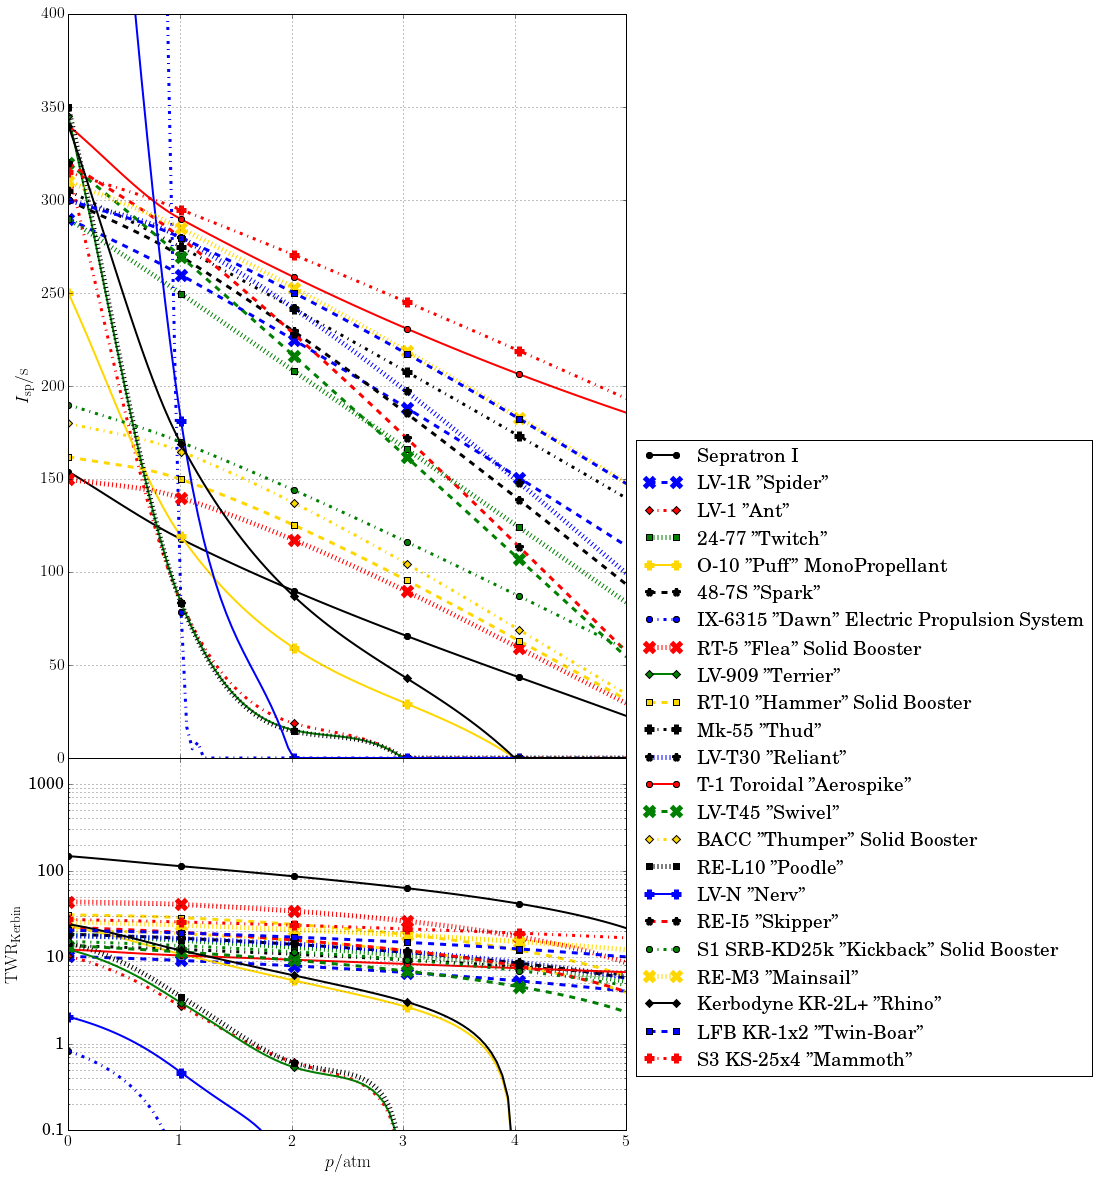

In [4]:
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=16)
import matplotlib.pyplot as plt
import numpy as np

from itertools import cycle
lss = ["-","--","-.",":"]
lscycle = cycle(lss)
lwcycle = cycle([2, 3, 3, 5])
colours = cycle(['black', 'blue', 'red', 'green', 'gold'])
colcycle = cycle(colours)
mkcycle = cycle(['o', 'x', 'D', 's', '+', '*'])
mscycle = cycle([6, 10, 6, 6, 10, 8])

fig, (ax_isp, ax_f) = plt.subplots(2, sharex=True, figsize=(10,20), gridspec_kw={"height_ratios": (2,1)})
for e in engines:
    ls = next(lscycle)
    lw = next(lwcycle)
    color = next(colcycle)
    marker = next(mkcycle)
    markersize = next(mscycle)
    mew=markersize-5
               
    p = np.linspace(0, 5, 100)
    isp = e.isp_func(p)
    f = e.fvac/e.isp_func(0) * isp 
    twr = f/(e.mass * g0)
    ax_isp.plot(p, isp, label=e.name, ls=ls, lw=lw, color=color,marker=marker,markersize=markersize,mew=mew,markevery=20)
    ax_f.plot(p, twr, ls=ls, lw=lw, color=color, marker=marker,markersize=markersize,mew=mew,markevery=20)
    #ax_f.plot(p, f, ls=ls, lw=lw, color=color)
    
fig.subplots_adjust(hspace=0)
ax_isp.set_ylabel(r"$I_{\mathrm{sp}}/\mathrm{s}$", fontsize=18)
ax_f.set_ylabel(r"$\mathrm{TWR_{Kerbin}}$", fontsize=18)
#ax_f.set_ylabel(r"$F_\mathrm{thrust}/\mathrm{kN}$", fontsize=18)
ax_f.set_xlabel(r"$p/\mathrm{atm}$", fontsize=18)
lgd = ax_isp.legend(loc='center left', bbox_to_anchor=(1, 0))
ax_isp.grid(True)
ax_isp.set_ylim([0, 400])
ax_f.set_ylim([0.1, 2000])
ax_f.set_yscale("log")
ax_f.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4G'))
ax_f.grid(True, which='both')

print "Saving figure..."
fig.savefig("engines_pressure2.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig("engines_pressure2.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')
print "Done."

fig.show()


In [ ]:
import matplotlib.pyplot as plt

markers = {u'D': u'diamond', 6: u'caretup', 7: u'caretdown', u's': u'square', u'|': u'vline', u'x': u'x', 5: u'caretright', u'^': u'triangle_up', u'd': u'thin_diamond', u'h': u'hexagon1', u'+': u'plus', u'*': u'star', u',': u'pixel', u'o': u'circle', u'.': u'point', u'1': u'tri_down', u'p': u'pentagon', u'3': u'tri_left', u'2': u'tri_up', u'4': u'tri_right', u'H': u'hexagon2', u'v': u'triangle_down', u'8': u'octagon', u'<': u'triangle_left', u'>': u'triangle_right'}
markers = list(markers.keys())

ps = [0., 0.5, 1., 5.] 
isps = [e.isp_func(ps) for e in engines]
thrust = [(e.fvac/e.isp_func(0)) * e.isp_func(ps) for e in engines]
twrs = [(e.fvac/e.isp_func(0)) * e.isp_func(ps) / (g0 * e.mass) for e in engines] 

fig, axs = plt.subplots(2,2,figsize=(15,15), sharex=True, sharey=True)
axs = axs.reshape(-1)


for i,(isp, twr) in enumerate(zip(isps,twrs)):
    e = engines[i]
    for i_p, p in enumerate(ps):
        axs[i_p].plot([twr[i_p]],[isp[i_p]], ms=10, marker=markers[i], label=e.name)


lgd = plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

for i, ax in enumerate(axs):
    ax.set_title("Pressure "+str(ps[i])+"atm")
    ax.set_ylabel("Isp")
    ax.set_xlabel("TWR")
    ax.set_xlim((0.1, 200))
    ax.set_ylim((10, 850))
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(which="both")

fig.savefig("isp_twr.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

The function $\texttt{n_e}$
---------

Calculates the number of engines $n_\mathrm{e}$ needed for a certain thrust to weight ratio $\mathrm{TWR}$.

### The maths
Tsiolkovsky rocket equation:

$$\Delta v = u \ln \left( \frac{m_\mathrm{dry} + m_\mathrm{fuel}}{m_\mathrm{dry}} \right)$$

where $u = I_\mathrm{sp} \cdot g_0$ is the exhaust velocity, $I_\mathrm{sp}$ is the specific impulse, $g_0 = 9.81 \mathrm{\frac{m}{s^2}}$ is the standard gravity.

$m_\mathrm{dry}$ is just the sum of the total mass of the engines $n_\mathrm{e} \cdot m_\mathrm{e}$ and the payload mass $m_\mathrm{p}$. Together with $m_\mathrm{fuel}$ this is just the launch mass.

We rewrite the above as 

$$e^\frac{\Delta v}{u} = \frac{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} + m_\mathrm{fuel}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}} = \frac{m_\mathrm{launch}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}}$$

Given that the thrust to weight ratio $\mathrm{TWR} = \frac{F_\mathrm{thrust}}{g_0 \cdot m_\mathrm{launch}}$ should be greater than some minimum $\mathrm{TWR} \geq \mathrm{TWR_{min}}$, this becomes ($F_\mathrm{thrust} = n_\mathrm{e} F_\mathrm{thrust,e}$)

$$e^\frac{\Delta v}{u} = \frac{ \frac{n_\mathrm{e} F_\mathrm{thrust,e}}{g_0 \cdot \mathrm{TWR}}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}} \leq \frac{ \frac{n_\mathrm{e} F_\mathrm{thrust,e}}{g_0 \cdot \mathrm{TWR_{min}}}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}}$$

which we can with some symbol juggling rearrange into

$$n_\mathrm{e} \geq \frac{m_\mathrm{p}}{\frac{F_\mathrm{thrust}}{g_0 \mathrm{TWR_{min}} e^{\Delta v / u}} - m_\mathrm{e}} $$

The function $\texttt{compute}$
---------

Starting from the result $n_e$ we can calculate the total mass of the craft that has the $\Delta v$ for the payload mass $m_\mathrm{p}$ we are looking for.

### The maths

Recall from above, that

$$e^\frac{\Delta v}{u} = \frac{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} + m_\mathrm{fuel}}{n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p}}$$

which can be easily written as


$$\left( n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} \right) e^\frac{\Delta v}{u} = n_\mathrm{e} \cdot m_\mathrm{e} + m_\mathrm{p} + m_\mathrm{fuel} = m_\mathrm{launch}$$

This means that for a given number of engines $n_\mathrm{e}$, Engine type ($I_\mathrm{sp}$, $F_\mathrm{thrust}$, $m_\mathrm{e}$) and target $\Delta v$ with payload mass $m_\mathrm{p}$, we can find the total mass of the craft.

### But what does it mean?

We do this for all engines, and the craft with the least mass is the best. Why, you may ask? Because one stage's mass is a lower stage's payload mass. And you see that exponential in there? That gets really ugly, really quickly. So the best stage configuration is that with the least total mass needed for the $\Delta v$ you wish to achieve for a payload mass.





In [5]:
#calculates number of engines needed to attain a certain TWR,
# with infinitely divisible, 0-dry-mass fuel tanks
def n_e(engine, M_p, Dv, min_twr=0, pressure=0, max_engine_count=np.inf):
    if (min_twr==0):
        return np.ones(np.shape(M_p)) #shape(M_p) *should* == shape(Dv)
    else:
        isp = e.isp_func(pressure)
        thrust = e.fvac * isp/e.isp_func(0)
        u = isp*g0
        
        #calculate engine count
        # via tsiolkovsky rocket eq, see above
        num = np.ceil(M_p/(thrust/(min_twr*g0*np.exp(Dv/u))-e.mass))
        
        forbidden = num>max_engine_count #mask array where engine count is greater than largest allowed
        num[forbidden] = np.inf #set forbidden
     
        forbidden = num<1 #mask array where engines needed is less than one (forbidden)
        num[forbidden] = np.inf #set forbidden
        return num


xmin=0.; xmax=10000.
ymin=0.1; ymax=1000.
res = (500,500)

# Add iterating arrays
#dv = np.arange(xmin, xmax, xmax/res[0]) #Δv
dv = np.linspace(xmin, xmax, num=res[0]) #Δv
m_p = np.logspace(np.log10(ymin), np.log10(ymax), num=res[1]) #payload mass
Dv, M_p = np.meshgrid(dv, m_p)

def compute(min_twr=0, pressure=0, max_engine_count=np.inf):
    #print "Computing..."
    #TODO iterate explicitly so that n is not calculated twice
    #TODO multiprocessing?

    # number of engines needed
    n = np.array([n_e(e,M_p,dv,min_twr=min_twr, pressure=pressure, max_engine_count=max_engine_count) for e in engines])
    
    # total mass
    M = np.array([(n_e(e,M_p,Dv,min_twr=min_twr, pressure=pressure, max_engine_count=max_engine_count)*e.mass+M_p)*np.exp(Dv/(g0*e.isp_func(pressure))) for e in engines])

    # index of engine with configuration of least mass
    I = np.argmin(M,axis=0)     

    b = np.sum(np.isinf(M), axis=0)==len(engines) #mask array where all engines were inf
    I[b] = len(engines) #set the index to len(engines) (out of bounds)

    #print "Done."
    return n, M, I

/usr/lib/python2.7/site-packages/matplotlib/axes/_base.py:1166: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))
/usr/lib/python2.7/site-packages/matplotlib/image.py:359: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")
/usr/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


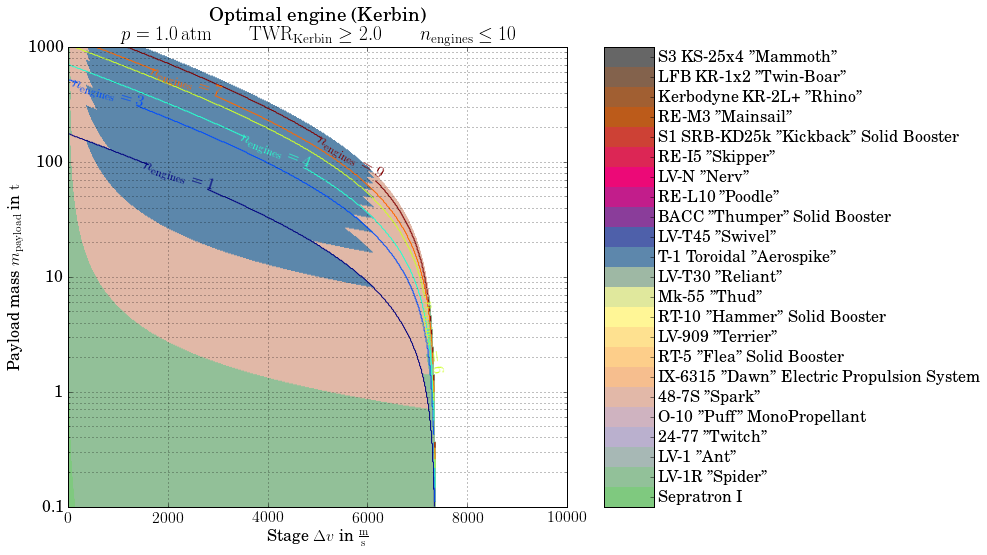

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#import mpld3
#mpld3.enable_notebook()

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=16)

#            twr  p   n_e name
plot_args = [(0., 0., 10, "Space"),
             (2., 5., 10, "Eve"),
             (2., 1., 10, "Kerbin"),
             (1., 0., 10, "Tylo"),
             (1., 0.6, 10, "Laythe"),
             (0.4, 0.2, 10, "Duna"),
             (0.35, 0., 10, "Moho, Vall"),
             (0.22, 0., 10, "Mun, Eeloo, Ike"),
             (0.15, 0., 10, "Dres"),
             (0.07, 0., 10, "Minmus, Bop")]


for args in plot_args[2:3]:
    n, M, I = compute(*(args[:-1]))
    min_twr, pressure, max_engine_count, name = args
    
    #print "Plotting..."
    fig, (ax, axcb) = plt.subplots(1, 2,figsize=(14,8), gridspec_kw={"width_ratios": (10,1)})
    ax.set_title(r"Optimal engine ("+name+")\n"+
                 r"$p="+str(pressure)+r"\,\mathrm{atm}$\qquad"
                 r"$\mathrm{TWR_{Kerbin}} \geq "+str(min_twr)+r"$\qquad" 
                 r"$n_\mathrm{engines} \leq "+str(max_engine_count).replace(r'inf',r'\infty')+"$")

    cmap_tmp = mpl.pyplot.cm.Accent
    cmaplist_tmp = [cmap_tmp(i) for i in range(cmap_tmp.N)]
    cmaplist_tmp[85] = (0.2,0.7,0.9,1.0)
    norm_eng = mpl.colors.BoundaryNorm(np.arange(len(engines)+1), cmap_tmp.N)
    cmap_eng = cmap_tmp.from_list('Custom cmap', cmaplist_tmp, cmap_tmp.N)
    cmap_eng.set_over('white')

    #plt.contour
    
    ax.set_yscale('log')
    ax.grid(True, which="both")   
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.4G'))
    ax.set_ylabel(r'Payload mass $m_\mathrm{payload}$ in $\mathrm{t}$')
    ax.set_xlabel(r'Stage $\Delta v$ in $\mathrm{\frac{m}{s}}$') 

    ax.imshow(I, extent=(xmin,xmax,ymin,ymax), origin="lower", cmap=cmap_eng, norm=norm_eng)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap_eng, norm=norm_eng, format=None, extend="neither", ticks=np.arange(len(engines))+0.5)                
    cb.ax.set_yticklabels([e.name for e in engines])
    

    n_inv = np.inf*np.ones(I.shape) #set to inf for out of bounds
    n_inv = np.expand_dims(n_inv,0) #to be able to concatenate, match dims
    n_ext = np.concatenate((n,n_inv)) #concatenate inf

    y,z = np.meshgrid(np.arange(n.shape[1]),np.arange(n.shape[2]), indexing='ij')
    n_oe = n_ext[I,y,z]
    #ax.imshow(n_oe, extent=(xmin,xmax,ymin,ymax), origin="lower")
    contour = ax.contour(Dv, M_p, n_oe)
    ax.clabel(contour, contour.levels, fmt=r"$n_\mathrm{engines}=%i$")
    
    #print "Done."
    fig.tight_layout()
    fig.savefig('optimalengine_'+name+'_p='+str(pressure)+"_nmax="+str(max_engine_count)+"_mintwr="+str(min_twr)+".png")
    plt.show()